# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import seaborn as sns
import gc  # garbage collector

import data_processing as dp  # own functions and logic
importlib.reload(dp)  # this makes it so that 
                      # the file with our functions is re-read every time, 
                      # in case we have made modifications

<module 'data_processing' from '/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/data_processing.py'>

# Configure path to data files

In [2]:
# define the path to the folder where the YouNiverse dataset is stored here

# when adding your own path, don't remove the existing path, just comment it
# in this way, everyone can quickly uncomment their own path
dataset_root_path = "/media/andreas/Backup Plus/Ada/youniverse_dataset/"   #andreas
#dataset_root_path = "D:/youniverse/"                                    #mila
# dataset_root_path = "/Volumes/DISQUE_SAUVEGARDE_MANON_LANDRIEUX/dataset/"  #manon
# dataset_root_path = "/Volumes/Backup/Youniverse dataset/"

# Preprocessing

## Loading the data

In [3]:
# load channel data (no chunks needed, as the file is not very large)
df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv.gz", compression="infer", sep="\t") #andreas 
# df_channels = pd.read_csv(dataset_root_path + "df_channels_en.tsv", compression="infer", sep="\t") # manon 

In [4]:
# load a small part of video and comment data, to try functions on them etc.
# these datasets should not be used for calculations, as they don't contain all the data

# load (first 100000 rows of) video data
df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", compression="infer", lines=True, nrows=100000) #andreas 
# df_videos = pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", compression="infer", lines=True, nrows=1000000) #manon
# load (first 1000000 rows of) comment data
df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", compression="infer", sep="\t", nrows=1000000) #andreas
# df_comments = pd.read_csv(dataset_root_path + "youtube_comments.tsv", compression="infer", sep="\t", nrows=1000000) #manon

In [5]:
# definition of "readers", i.e., objects that we can iterate through 
# and always get a chunk of the dataframe in each iteration

def videos_in_chunks(chunksize: int = 100000) -> pd.io.json._json.JsonReader:
    """
    Returns a Json reader which can be iterated through, to get chunks of the (unfiltered) video dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the Json reader
    """
    return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl.gz", #andreas
    # return pd.read_json(dataset_root_path + "yt_metadata_en.jsonl", #manon
                        compression="infer", lines=True, chunksize=chunksize, )
                        # nrows=1000000, )   # uncomment this to only use the first million videos, for testing
                                           # (remove the paranthesis above as well)

def comments_in_chunks(chunksize: int = 1000000) -> pd.io.parsers.readers.TextFileReader:
    """
    Returns a CSV reader which can be iterated through, to get chunks of the (unfiltered) comment dataset.

    Args:
        chunksize: number of entries in each chunk

    Returns:
        the CSV reader
    """
    return pd.read_csv(dataset_root_path + "youtube_comments.tsv.gz", #andreas
    # return pd.read_csv(dataset_root_path + "youtube_comments.tsv", #manon
                       compression="infer", sep="\t", chunksize=chunksize, )
                    #    nrows = 10000000)  # uncomment this to only use the first 10 million comments, for testing
                                            # (remove the paranthesis above as well)

# Intro : topics distribution on YouTube
**Note for us:** (the actual analysis is still a **todo**) 
With this analysis we want to investigate how popular the News&Politics category is both in videos and channels. This could possibly be used to justify our choice, but can also just be an interesting view, to see how big the fraction of YouTube that we are analyzing actually is.

,category_cc,number_of_channels
0,Autos & Vehicles,3705
1,Comedy,3767
2,Education,7803
3,Entertainment,22951
4,Film and Animation,6875
5,Gaming,20143
6,Howto & Style,11875
7,Music,24285
8,News & Politics,2263
9,Nonprofits & Activism,969


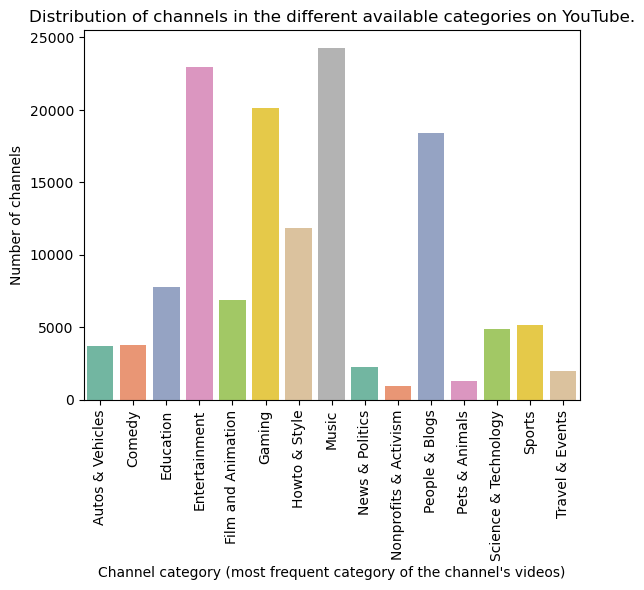

In [ ]:
#distribution of categories for the channels 
category_channel= df_channels.groupby('category_cc').agg(number_of_channels=('category_cc', 'size')).reset_index()
display(category_channel)
category_channel.to_csv(dataset_root_path + "../generated_data/channel_count_per_category.csv")

ax = sns.barplot(x="category_cc", y="number_of_channels", data=category_channel,hue="category_cc", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of channels in the different available categories on YouTube.")
plt.xlabel("Channel category (most frequent category of the channel's videos)")
plt.ylabel("Number of channels")
plt.show()

In [7]:
# #distribution of categories for the videos for the first 100000 rows 

# category_videos= df_videos.groupby('categories').agg(number_of_videos=('categories', 'size')).reset_index()
# display(category_videos)
# ax = sns.barplot(x="categories", y="number_of_videos", data=category_videos,hue="categories", palette='Set2')
# plt.xticks(rotation=90)
# plt.show()

# #even if it isnt on the whole dataset (only on 1000000 first rows) we see here that the news & politics is a popular category for videos comapred to channels 

In [ ]:
#distribution categories of videos over the whole dataset per chunck

# Define a function that processes a single chunk
def count_videos_by_category(chunk):
    # Count videos in each category within the chunk
    category_counts = chunk['categories'].value_counts().to_frame().T  # Get counts and transpose for one-row DataFrame
    category_counts.columns.name = None  # Remove column name for easy concatenation
    return category_counts

# Apply the function to all chunks and get the results concatenated
category_counts_per_chunk = dp.run_simple_function_on_chunks_concat(
    videos_in_chunks(chunksize=100000), 
    count_videos_by_category,
    print_time=(100000, 72924794)
)

# Sum the counts across all chunks to get the total count of videos per category
total_category_counts = category_counts_per_chunk.sum().to_frame(name='total_count').reset_index()
total_category_counts.columns = ['category', 'total_count']

total_category_counts.to_csv(dataset_root_path + "../generated_data/video_count_by_category.csv")  # save the created dataframe so we don't have to generate it again

# Display the final distribution
print(total_category_counts)

category_videos_whole_dataset= total_category_counts.groupby('category').agg(
    number_of_videos=('category', 'size')).reset_index()

display(category_videos_whole_dataset)
ax = sns.barplot(x="category", y="total_count", data=total_category_counts,hue="category", palette='Set2')
plt.xticks(rotation=90)
plt.title("Distribution of videos in the different available categories on YouTube.")
plt.xlabel("Video category")
plt.ylabel("Number of videos")
plt.show()

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
2.517 secs per chunk on average. Meaning  30.545 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
2.903 secs per chunk on average. Meaning  35.191 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
2.944 secs per chunk on average. Meaning  35.633 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
2.797 secs per chunk on average. Meaning  33.814 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
2.674 secs per chunk on average. Meaning  32.272 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
2.592 secs per chunk on average. Meaning  31.250 minutes left.


KeyboardInterrupt: 

In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


## TODO
We still need an interpretation/analysis of what we see here (in the above plots).

Something like (check this, this is just from the top of my head) "we see that there are not that many News & Politics channels compared to the other categories, however there are a much larger fraction of News & Politics *videos*. Therefore, we conclude that the News & Politics channels post videos rather actively."

Here is also an idea which Mila (I think) wrote: instead of saying it goes in our way we could say , that it is already a small category which can lead to more isolation as people are less interested 
and there exists less various sources thus clustering can happen more easily 



Is there something else which we want to analyze based on the results here which we still want to analyze?

**Also**: There seem to be videos without a category (however no channels without a category). This must be adressed, either in a general NaN filtering in the beginning (if we do that) or here. We could for instance look at what videos they are, are they all old, do they have something else in common?



## Filtering for NaNs and ' ' (here in youtube_comments.tsv.gz)

**Question:** should this maybe be the first thing we do? So before we even look at the distribution of videos and channels across categories? So we first do the filtering of "good" data, and then start looking at the actual content of the data

Pending questions to TA (good practices): 
- is the analysis of useless data (NaN and '' rows) required for justification of their removal, or can we just go with the filtering only ?
- are we allowed to filter once the dataset is already reduced to e.g one channel, or do we have to filter in the very beginning (painful) ?

## Note
The code below will likely not work on the whole dataframe, because it's going to be (almost) as large as the initial comments dataset, and hence to large too large to handle. Therefore, it is in particular also too large to generate like this.

It could however be rewritten to use the functionality "save_every" of the function run_simple_function_on_chunks_concat, which will save the data as a csv every X chunks, meaning that the memory doesn't get too large. This would maybe get a bit messy, because we would then have to work with very many files at the same time.

In [ ]:
# #replace empty character '' with NaN and remove rows containing NaN

# filtered_df = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
#                                         lambda x: x.replace('', np.nan).dropna(),
#                                         print_time=(1000000, 8600000000))

In [ ]:
#filtered df
# display(filtered_df)

If we have to analyze NaN rows before filtering, then use this code:

In [ ]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# get the entries of the comment dataframe which have a na value in any column
nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                        lambda x: dp.get_na_entries(x, "any", reverse=False),
                                        print_time=(1000000, 8600000000))

nans.to_csv("../data/nan_rows_in_comment_dataset.csv")

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
0.713 secs per chunk on average. Meaning  102.192 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
0.787 secs per chunk on average. Meaning  112.750 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
0.780 secs per chunk on average. Meaning  111.739 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
0.752 secs per chunk on average. Meaning  107.766 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
0.764 secs per chunk on average. Meaning  109.422 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
0.760 secs per chunk on average. Meaning  108.815 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/data_processing.py:79: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Going through chunk 6322...
The first 6323000000 entries have been processed. 2277000000 left.
0.763 secs per chunk on average. Meaning  28.938 minutes left.


/home/andreas/Nextcloud/Dokumente/Uni/Module/3sem-EPFL/ada/Project/ada-2024-project-thedataminions/analysis/data_processing.py:79: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(reader):


Going through chunk 6323...
The first 6324000000 entries have been processed. 2276000000 left.
0.763 secs per chunk on average. Meaning  28.926 minutes left.
Going through chunk 6324...
The first 6325000000 entries have been processed. 2275000000 left.
0.763 secs per chunk on average. Meaning  28.914 minutes left.
Going through chunk 6325...
The first 6326000000 entries have been processed. 2274000000 left.
0.763 secs per chunk on average. Meaning  28.901 minutes left.
Going through chunk 6326...
The first 6327000000 entries have been processed. 2273000000 left.
0.763 secs per chunk on average. Meaning  28.888 minutes left.
Going through chunk 6327...
The first 6328000000 entries have been processed. 2272000000 left.
0.763 secs per chunk on average. Meaning  28.876 minutes left.
Going through chunk 6328...
The first 6329000000 entries have been processed. 2271000000 left.
0.763 secs per chunk on average. Meaning  28.863 minutes left.
Going through chunk 6329...
The first 6330000000 ent

In [ ]:
display(nans)

,author,video_id,likes,replies


In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


In [ ]:
# commented right now because I'm not 100 % sure if it will work on the complete dataframe

# count the entries of the comment dataframe which have a na value in any column

counted_nans = dp.run_simple_function_on_chunks_concat(comments_in_chunks(), 
                                                lambda x: dp.count_na_entries(x, "any", reverse=False),
                                                print_time=(1000000, 8600000000)).sum(axis=0)

counted_nans.to_csv("../data/counted_nans_in_comment_data.csv")

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
0.894 secs per chunk on average. Meaning  128.166 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
0.953 secs per chunk on average. Meaning  136.553 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
0.904 secs per chunk on average. Meaning  129.528 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
0.883 secs per chunk on average. Meaning  126.467 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
0.855 secs per chunk on average. Meaning  122.424 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
0.847 secs per chunk on average. Meaning  121.359 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# display(counted_nans)

In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


## Filtering the datasets to our needs

### Filtering **videos** by category 'News & Politics'

In [ ]:
# filter the video dataframe to only include videos from n&p category

# Note: no DataFrame is created here, as it would be too big for the computer to handle 
# (too many videos are in the News & Politics category).
# Therefore, instead every 300 chunks, a compressed csv file is saved with the filtered data so far

# To actually use that data, these files will have to be loaded and used separately.

dp.run_simple_function_on_chunks_concat(videos_in_chunks(chunksize=100000),
                                        lambda x: x[x.categories == "News & Politics"], 
                                        print_time=(100000, 72924794),
                                        save=dataset_root_path + "/../generated_data/videos_in_news_pol",
                                        save_every=300,
                                        compress=".gz")

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
3.971 secs per chunk on average. Meaning  48.203 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
4.050 secs per chunk on average. Meaning  49.091 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
4.080 secs per chunk on average. Meaning  49.390 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.967 secs per chunk on average. Meaning  47.956 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.805 secs per chunk on average. Meaning  45.925 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.696 secs per chunk on average. Meaning  44.555 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.690 secs per chunk

In [ ]:
# load the first file (corresponding to the first 300 chunks) and display
print("News & Politics videos found in the first 300 chunks of the video dataset")
display(pd.read_csv(dataset_root_path + "/../generated_data/videos_in_news_pol__0_299.csv.gz"))

print(gc.collect())  # collect garbage as this data (which was just loaded) is not needed anymore here

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
60001328,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:29.025236,If you're joining American Towman for the annu...,0.0,QThfRHnKbCw,274,0.0,"12,08,02,ATTV,Show,Saturday,720p","San Antonio ""Tow Expo International"" -- Day 2:...",2012-08-02 00:00:00,163.0
60001333,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:32.818688,There are several ways some companies steal or...,6.0,4MI_MPfl5bI,251,52.0,"poaching,youtube",The Dirty Business of Poaching Tow Calls,2012-07-03 00:00:00,13910.0
60001334,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:36.714021,A woman's story of being set on fire strikes a...,1.0,JGAkibyb8qs,192,2.0,youyube,Tow Boss Assists Woman Set on Fire in Florida,2012-06-28 00:00:00,759.0
60001335,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:40.318780,The rainy summer season in Florida can cause u...,1.0,ZjqHusNm2oA,128,4.0,"Florida,Flooding,youtube",Towman Helps Teens Stuck in Florida Flooding,2012-06-27 00:00:00,463.0
60001343,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:47.870235,Buffalo city officials are changing key towing...,0.0,6lCUY_N-PTY,140,1.0,"buffalo,youtube","Towing Policies Changed in Buffalo, NY in Resp...",2012-05-30 00:00:00,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72924789,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:02.294620,Shri Manoj Kumar Tiwari's speech during Motion...,3.0,YQLoxwLpjSU,270,67.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Manoj Kumar Tiwari's speech during Motion...,2017-02-06 00:00:00,4409.0
72924790,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:06.401481,Shri La Ganesan's speech during Motion of Than...,0.0,mINQHg1QBcg,878,21.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri La Ganesan's speech during Motion of Than...,2017-02-06 00:00:00,1172.0
72924791,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:09.530822,Shri Mukhtar Abbas Naqvi's speech during Motio...,2.0,x20aNOWh1yI,1003,35.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",Shri Mukhtar Abbas Naqvi's speech during Motio...,2017-02-06 00:00:00,1898.0
72924792,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:46:00.080054,BJP submitted complaint to EC against Chief Se...,0.0,-Nn6FL2gqEw,755,27.0,"BJP,Bharatiya Janata Party,BJP videos,Yuva TV,...",BJP submitted complaint to EC against Chief Se...,2017-02-06 00:00:00,726.0


In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

0


### Filtering **channels** by category News & Politics

In [ ]:
#filter channels dataset to only include n&p

# Note: because the channel dataset is much smaller than the video dataset, we don't need to worry about chunks here
# Also, the results can be saved in a single file without a problem.
df_channels_news_pol = df_channels[df_channels.category_cc == "News & Politics"]

df_channels_news_pol.to_csv(dataset_root_path + "../generated_data/channels_in_news_pol.csv")

In [ ]:
display(df_channels_news_pol.head())
display(df_channels_news_pol.shape)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
129,News & Politics,2006-08-26,UCttspZesZIDEwwpVIgoZtWQ,IndiaTV,15177282,139814,199.0,2.0870
133,News & Politics,2012-06-01,UCRWFSbif-RFENbBrSiez1DA,ABP NEWS,16274836,129027,207.0,2.0870
212,News & Politics,2017-03-03,UCmphdqZNmqL72WJ2uyiNw5w,ABP NEWS HINDI,10800000,51298,340.0,2.0870
268,News & Politics,2015-03-23,UCx8Z14PpntdaxCt2hakbQLQ,The Lallantop,9120000,9423,438.0,2.0870
337,News & Politics,2007-06-19,UCIvaYmXn910QMdemBG3v1pQ,Zee News,9280000,102648,549.0,2.0870
...,...,...,...,...,...,...,...,...
135820,News & Politics,2010-08-07,UC5rxiCGcNunIi5zI1hMYLMg,Salman Akhtar,10400,40,962468.0,53.1435
135825,News & Politics,2013-02-01,UCLSEJQ8TWtlEkaytaa4Y7lw,WingsOfChrist,10420,61,962547.0,53.1435
135901,News & Politics,2012-10-19,UCnkG_c5cyemVVsgCDoHiXew,The American Mirror,10500,329,963417.0,53.1435
136231,News & Politics,2017-11-25,UC69lWS7UMbBQc-9yqp4nGjA,Patriotism Show,10320,46,975448.0,53.1435


## Todo:
The code below should be formalized into a function.

(something like: you give a list of files to go through, then you give it a function which it should apply to the content of each file, then in concatenates the results.
so basically like run_simple_fct_on_chunks_concat, just for separate files and not for chunks)



In [ ]:
# check if all videos we found in news&pol are also pulished by a channel in category n&p

# go through all of the three files we generated, containing data about videos in News&Pol
for filepath in [dataset_root_path + "/../generated_data/videos_in_news_pol__0_299.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__300_599.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__500_729.csv.gz"]:
    
    # create empty dataframe (which will later contain all videos in News & Pol which are not uploaded by a News & Pol channel)
    df_videos_news_pol__channel_not_news_pol = pd.DataFrame()

    # using the current filepath, read the file and use it as a (temporary) df called df_videos_news_pol
    with pd.read_csv(filepath) as df_videos_news_pol:
        # concatenate the precious results with the results from the current file
        df_videos_news_pol__channel_not_news_pol = pd.concat([df_videos_news_pol__channel_not_news_pol,
             df_videos_news_pol[
                 np.logical_not(df_videos_news_pol.channel_id.isin(df_channels_news_pol.channel)
                                )]
            )])
        
display(df_videos_news_pol__channel_not_news_pol.head())
display(df_videos_news_pol__channel_not_news_pol.shape)

df_videos_news_pol__channel_not_news_pol.to_csv(dataset_root_path + "../generated_data/videos_in_news_pol__channel_not_in_news_pol.csv")
        



,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
60001328,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:29.025236,If you're joining American Towman for the annu...,0.0,QThfRHnKbCw,274,0.0,"12,08,02,ATTV,Show,Saturday,720p","San Antonio ""Tow Expo International"" -- Day 2:...",2012-08-02 00:00:00,163.0
60001333,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:32.818688,There are several ways some companies steal or...,6.0,4MI_MPfl5bI,251,52.0,"poaching,youtube",The Dirty Business of Poaching Tow Calls,2012-07-03 00:00:00,13910.0
60001334,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:36.714021,A woman's story of being set on fire strikes a...,1.0,JGAkibyb8qs,192,2.0,youyube,Tow Boss Assists Woman Set on Fire in Florida,2012-06-28 00:00:00,759.0
60001335,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:40.318780,The rainy summer season in Florida can cause u...,1.0,ZjqHusNm2oA,128,4.0,"Florida,Flooding,youtube",Towman Helps Teens Stuck in Florida Flooding,2012-06-27 00:00:00,463.0
60001343,News & Politics,UC7OA4qz1cPMy7_2wG731LnA,2019-11-04 04:21:47.870235,Buffalo city officials are changing key towing...,0.0,6lCUY_N-PTY,140,1.0,"buffalo,youtube","Towing Policies Changed in Buffalo, NY in Resp...",2012-05-30 00:00:00,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72907313,News & Politics,UCrwHteI3lioIHbZF5iDRdBw,2019-10-30 23:46:03.911918,Atlanta Fine Homes 2013 Spring Real Estate Mar...,0.0,SB2XC_yH7WA,264,1.0,"Virtual Studio Innovations,The VSI Group,AFH,A...",Atlanta Fine Homes 2013 Spring Real Estate Mar...,2013-03-07 00:00:00,385.0
72907373,News & Politics,UCrwHteI3lioIHbZF5iDRdBw,2019-10-30 23:46:38.996884,765 East Northway Lane\n\nVirtual Studio Innov...,0.0,2seTjusi7KU,133,8.0,"Heery Brothers,George Heery,Neal Heery,765 Eas...",Atlanta Real Estate Market - 765 East Northway...,2012-07-11 00:00:00,582.0
72907492,News & Politics,UCrwHLlgnIciUKVLGOO_LANg,2019-11-07 01:48:08.384683,#VINAYCONNECTS\nReversed water purifier.\nColo...,0.0,1eTyzeYc8Bg,132,11.0,"Reversed video,coloured water into drinking wa...",Satisfying reverse video,2018-07-25 00:00:00,190.0
72907791,News & Politics,UCrwGDSxsQPqyoy_gZs9ydrw,2019-11-13 02:28:45.404263,TWITTER:@SincerelyOghosa\nINSTAGRAM:@Sincerely...,17.0,VoCUD2DpD_U,184,117.0,"Review,Hair,RPGshow,kim kardashian lace wig,dy...",RPG SHOW LACE WIG REVIEW,2013-08-01 00:00:00,9276.0


**We see that indeed, not all videos in the news and politics category belong to a channel in this category!**
A google search shows that apparently, you don't have to have the same category for all videos, but you set a "default" channel category which will be used for videos if you don't change it manually. Also, you can probably change the default category after a while if you want.

This is the reason why most of the news&pol videos are uploaded by a news&pol channe, but not all.

In the paper about the dataset, the authors say that the channel category is actually the "most frequent category", so I guess the video categories are the most relevant, as they are the true categories.

We could try to verify this, if we want to.

In [ ]:
# run garbage collector and print how much garbage was collected
collector = gc.collect()

print(collector)

31


### Filtering the N&P videos by a list of channels

## Todo:
when the function to run stuff on several files and concatenate (see previous todo) is done, the below code should be rewritten to use that fct

In [ ]:
# form the filtered N&P videos dataframe, keep those posted by channels manually selected (here CNN, ABC News, BBC News, Al Jazeera English and Fox News)

# go through all of the three files we generated, containing data about videos in News&Pol
for filepath in [dataset_root_path + "/../generated_data/videos_in_news_pol__0_299.csv.gz", 
                 dataset_root_path + "/../generated_data/videos_in_news_pol__300_599.csv.gz",
                 dataset_root_path + "/../generated_data/videos_in_news_pol__500_729.csv.gz"]:
    
    # create empty dataframe (which will later contain all videos in News & Pol which are not uploaded by a News & Pol channel)
    df_videos_news_pol_manually_selected = pd.DataFrame()

    # using the current filepath, read the file and use it as a (temporary) df called df_videos_news_pol
    with pd.read_csv(filepath) as df_videos_news_pol:
        # concatenate the precious results with the results from the current file
        df_videos_news_pol_manually_selected = pd.concat([df_videos_news_pol_manually_selected,
             df_videos_news_pol[df_videos_news_pol.channel_id.isin(["UCupvZG-5ko_eiXAupbDfxWw",  # CNN
                                                                    "UCBi2mrWuNuyYy4gbM6fU18Q",  # ABC News
                                                                    "UC16niRr50-MSBwiO3YDb3RA",  # BBC News
                                                                    "UCNye-wNBqNL5ZzHSJj3l8Bg",  # Al Jazeera English
                                                                    "UCXIJgqnII2ZOINSWNOGFThA",  # Fox News
                                                                  ])]
            )])
        
display(df_videos_news_pol_manually_selected.head())
display(df_videos_news_pol_manually_selected.shape)

df_videos_news_pol_manually_selected.to_csv(dataset_root_path + "../generated_data/videos_from_news_pol_from_selected_channels.csv")

### Doing our own ranking of N&P channels (not necessary)

We don't have to do an analysis of channel popularity to justify our choice of channels.

We could however do some simple thing like showing where they are on the ranking in the dataset (as the statistic we used is from 2024 (I guess) and the dataset is older)

### Todo?? 

In [ ]:
# sort the previously filtered n&p channels by subscriber count according to channel crawler
#df_channels_news_pol_sort_subscribers = df_channels_news_pol.sort_values(by="subscribers_cc", ascending=False)

In [ ]:
#display(df_channels_news_pol_sort_subscribers)

### Filtering news & pol **videos** in a specific channel

In [ ]:
# filter the video dataset to get only videos from a specific channel (here: CNN, as an example)

df_videos_news_pol_cnn = df_videos_news_pol_manually_selected.loc[
    df_videos_news_pol_manually_selected.channel_id == "UCupvZG-5ko_eiXAupbDfxWw"]

df_videos_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/videos_news_pol_cnn.csv")

# below is old code, which actually goes through the complete video dataset (in chunks) 
# to find the videos from a specific channel.
# This is not necessary, as the only benefit is that we get videos from any cateory, but we are actually 
# only interested in News & Pol videos

# videos_from_channel_test = dp.run_simple_function_on_chunks_concat(
#     videos_in_chunks(chunksize=100000),
#     lambda x: x.loc[x.channel_id == "UCzWrhkg9eK5I8Bm3HfV-unA"],
#     print_time=(100000, 72924794))

# videos_from_channel_test.to_csv("../data/videos_from_channel_UCzWrhkg9eK5I8Bm3HfV-unA_test.csv")

Going through chunk 0...
The first 100000 entries have been processed. 72824794 left.
4.044 secs per chunk on average. Meaning  49.086 minutes left.
Going through chunk 1...
The first 200000 entries have been processed. 72724794 left.
3.865 secs per chunk on average. Meaning  46.844 minutes left.
Going through chunk 2...
The first 300000 entries have been processed. 72624794 left.
3.976 secs per chunk on average. Meaning  48.124 minutes left.
Going through chunk 3...
The first 400000 entries have been processed. 72524794 left.
3.921 secs per chunk on average. Meaning  47.398 minutes left.
Going through chunk 4...
The first 500000 entries have been processed. 72424794 left.
3.811 secs per chunk on average. Meaning  46.005 minutes left.
Going through chunk 5...
The first 600000 entries have been processed. 72324794 left.
3.694 secs per chunk on average. Meaning  44.527 minutes left.
Going through chunk 6...
The first 700000 entries have been processed. 72224794 left.
3.687 secs per chunk

### Filtering **comments** from news & pol videos in a specific channel

This second function probably needs to look like this, as we haven't preprocessed the comment data yet, so it is still too big to be considered all at once, so we need the chunks.

## Todo:
probably (possibly?), we will also have to filter for NaN and empty values here.
Unless we already did that earlier.

In [ ]:
# get comments on (n&p) videos from a specific channel (here: CNN) using the ids from filtered video dataset

df_comments_news_pol_cnn = dp.run_simple_function_on_chunks_concat(
    comments_in_chunks(chunksize=1000000), 
    lambda df: df[df.video_id.isin(df_videos_news_pol_cnn.display_id)],
    print_time=(1000000, 8600000000))

df_comments_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/comments_news_pol_cnn.csv")

Going through chunk 0...
The first 1000000 entries have been processed. 8599000000 left.
1.307 secs per chunk on average. Meaning  187.343 minutes left.
Going through chunk 1...
The first 2000000 entries have been processed. 8598000000 left.
1.332 secs per chunk on average. Meaning  190.866 minutes left.
Going through chunk 2...
The first 3000000 entries have been processed. 8597000000 left.
1.380 secs per chunk on average. Meaning  197.719 minutes left.
Going through chunk 3...
The first 4000000 entries have been processed. 8596000000 left.
1.355 secs per chunk on average. Meaning  194.056 minutes left.
Going through chunk 4...
The first 5000000 entries have been processed. 8595000000 left.
1.363 secs per chunk on average. Meaning  195.188 minutes left.
Going through chunk 5...
The first 6000000 entries have been processed. 8594000000 left.
1.374 secs per chunk on average. Meaning  196.753 minutes left.
Going through chunk 6...
The first 7000000 entries have been processed. 8593000000

In [ ]:
display(df_comments_news_pol_cnn.head())
display(df_comments_news_pol_cnn.shape)

,author,video_id,likes,replies
6868268,453667,3vQK78eUg2A,2,1
7094579,468696,SWZG-ba1qDk,15,18
8912192,594074,hn2zYwqSINY,0,1


### Plots 
1. Using the previous functions, plot the tot nb of comments and/or subscribers in the selected channels (all on same plot).

2. For each channel, plot the distribution of comments for all the users.

## Selecting the cluster of users in a specific channel 

(flexible function where you give the threshold of x comments)


In [ ]:
#returns df with users_id and total number of comments made in a specific channel
def get_metadata_commenters(comment_data: pd.DataFrame, threshold: int = 0) -> pd.DataFrame:
    """
    Generates a dataframe with comment count and number of videos commented under, 
    for each person that has commented.
    Works on any df containing a set of comment data 
    (e.g., filtered to contain only comments under videos from a certain channel).

    Args:
        comment_data: df containing the comments for which to generate metadata
        threshold: (default 0) only commenters with more than this amount of comments 
            will be included in the dataframe.

    Returns:
        df with columns author, number of comments and number of videos
    """

    metadata_commenters = comment_data.groupby('author').agg(number_of_comments=('author', 'size')).reset_index()
    metadata_commenters['number_of_videos']= comment_data.groupby('author')['video_id'].nunique().values
    
    #keep users that wrote more than <threshold> comments 
    metadata_commenters=metadata_commenters[metadata_commenters['number_of_comments']>=threshold]
    return metadata_commenters

#test with threshold=0
metadata_commenters_news_pol_cnn = get_metadata_commenters(df_comments_news_pol_cnn,0)

metadata_commenters_news_pol_cnn.to_csv(dataset_root_path + "../generated_data/commenter_metadata_news_pol_cnn.csv")

display(metadata_commenters_news_pol_cnn.head())
display(metadata_commenters_news_pol_cnn.shape)

,author,number_of_comments,number_of_videos
0,453667,1,1
1,468696,1,1
2,594074,1,1


### Plots
1. Venn diagram with clusters of the channels and underline overlaps

# Deeper analysis and statistics
Todo: 
create dataset of all comments which are under a video in the news and politics category

use this dataset to get the list of videos under which each of the users we found (above) have made a comment

for each pair of users, calculate "number of videos in common (under which both have commented) / min number of videos both users have commented on"
(example: mila commented on 10 videos, andreas on 100 videos, they have 8 videos they both commented on, so the value we calculate is 8/10 = 0.8)
